In [109]:
%load autoreload

ValueError: 'autoreload' was not found in history, as a file, url, nor in the user namespace.

In [110]:
%auoreload

UsageError: Line magic function `%auoreload` not found.


In [1]:
import sys
import torch
from itertools import groupby
from datasets import load_dataset
import matplotlib.pyplot as plt


from charsiu.src.Charsiu import Wav2Vec2ForFrameClassification, CharsiuPreprocessor_en, charsiu_forced_aligner, charsiu_chain_attention_aligner, charsiu_chain_forced_aligner, charsiu_predictive_aligner
from charsiu.src.utils import seq2duration

/home/tomi/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# download timit
timit = load_dataset('timit_asr', data_dir='/home/tomi/Documents/tesis_speechRate/timit')


/home/tomi/.local/lib/python3.10/site-packages/datasets/load.py:1461: FutureWarning: The repository for timit_asr contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/timit_asr
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [3]:
# load data
sample = timit['train'][1]
text = sample['text']
audio_path = sample['file']
print('Text transcription:%s'%(text))
print('Audio path: %s'%audio_path)

Text transcription:Don't ask me to carry an oily rag like that.
Audio path: /home/tomi/Documents/tesis_speechRate/timit/data/TRAIN/DR1/FCJF0/SA2.WAV


Phone recognizer + Neural Forced Alignment

In [4]:
# load model
charsiu = charsiu_chain_attention_aligner(aligner='charsiu/en_w2v2_fs_10ms',recognizer='charsiu/en_w2v2_ctc_libris_and_cv')
charsiu.recognizer

/home/tomi/.local/lib/python3.10/site-packages/transformers/configuration_utils.py:363: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
/home/tomi/.local/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of the model checkpoint at charsiu/en_w2v2_fs_10ms were not used when initializing Wav2Vec2ForAttentionAlignment: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.c

Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder)

In [5]:
alignment = charsiu.align(audio=audio_path)

/home/tomi/Documents/tesis_speechRate/charsiu/src/Charsiu.py:372: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  audio = torch.tensor(audio).float().unsqueeze(0).to(self.device)


In [6]:


charsiu.recognizer()

TypeError: Wav2Vec2ForCTC.forward() missing 1 required positional argument: 'input_values'

In [7]:
print(alignment)
print('\n Ground Truth \n')
print([(s/16000,e/16000,p) for s,e,p in zip(sample['phonetic_detail']['start'],sample['phonetic_detail']['stop'],sample['phonetic_detail']['utterance'])])

[(0.0, 0.1, '[UNK]'), (0.1, 0.16, 'S'), (0.16, 0.19, '[UNK]'), (0.19, 0.21, 'L'), (0.21, 0.26, '[UNK]'), (0.26, 0.29, 'D'), (0.29, 0.31, 'T'), (0.31, 0.43, '[UNK]'), (0.43, 0.48, 'S'), (0.48, 0.52, 'K'), (0.52, 0.55, 'M'), (0.55, 0.59, '[UNK]'), (0.59, 0.6, 'Y'), (0.6, 0.63, 'T'), (0.63, 0.64, '[UNK]'), (0.64, 0.67, 'W'), (0.67, 0.75, 'K'), (0.75, 0.87, '[UNK]'), (0.87, 0.9, 'R'), (0.9, 0.93, '[UNK]'), (0.93, 0.94, 'Y'), (0.94, 0.99, '[UNK]'), (0.99, 1.02, 'N'), (1.02, 1.03, '[UNK]'), (1.03, 1.04, 'N'), (1.04, 1.05, '[UNK]'), (1.05, 1.1, 'Y'), (1.1, 1.11, 'W'), (1.11, 1.13, 'Y'), (1.13, 1.17, 'W'), (1.17, 1.18, '[UNK]'), (1.18, 1.19, 'W'), (1.19, 1.25, '[UNK]'), (1.25, 1.33, 'L'), (1.33, 1.41, 'R'), (1.41, 1.56, '[UNK]'), (1.56, 1.6, 'G'), (1.6, 1.63, 'L'), (1.63, 1.65, '[UNK]'), (1.65, 1.66, 'Y'), (1.66, 1.7, '[UNK]'), (1.7, 1.72, 'K'), (1.72, 1.77, '[UNK]'), (1.77, 1.79, 'S'), (1.79, 1.8, 'D'), (1.8, 1.82, 'S'), (1.82, 1.96, '[UNK]'), (1.96, 2.04, 'L'), (2.04, 2.14, '[UNK]')]

 Groun

In [8]:
charsiu.serve(audio=audio_path, save_to='sample.TextGrid')

/home/tomi/Documents/tesis_speechRate/charsiu/src/Charsiu.py:372: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  audio = torch.tensor(audio).float().unsqueeze(0).to(self.device)


Alignment output has been saved to sample.TextGrid


In [9]:
# load model
charsiu = charsiu_chain_forced_aligner(aligner='charsiu/en_w2v2_fc_10ms',recognizer=None)

/home/tomi/.local/lib/python3.10/site-packages/transformers/configuration_utils.py:363: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of the model checkpoint at charsiu/en_w2v2_fc_10ms were not used when initializing Wav2Vec2ForFrameClassification: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForFrameClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForFrameClassification from the checkpoint of a model that you expect to be exa

OSError: None is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

In [ ]:
alignment = charsiu.align(audio=audio_path)

In [ ]:
print(alignment)
print('\n Ground Truth \n')
print([(s/16000,e/16000,p) for s,e,p in zip(sample['phonetic_detail']['start'],sample['phonetic_detail']['stop'],sample['phonetic_detail']['utterance'])])

In [ ]:
charsiu.serve(audio=audio_path, save_to='sample.TextGrid')

Direct inference with frame classification model

In [ ]:
charsiu = charsiu_predictive_aligner(aligner='charsiu/en_w2v2_fc_10ms')

In [ ]:
alignment = charsiu.align(audio=audio_path)

In [10]:
print(alignment)
print('\n Ground Truth \n')
print([(s/16000,e/16000,p) for s,e,p in zip(sample['phonetic_detail']['start'],sample['phonetic_detail']['stop'],sample['phonetic_detail']['utterance'])])

[(0.0, 0.1, '[UNK]'), (0.1, 0.16, 'S'), (0.16, 0.19, '[UNK]'), (0.19, 0.21, 'L'), (0.21, 0.26, '[UNK]'), (0.26, 0.29, 'D'), (0.29, 0.31, 'T'), (0.31, 0.43, '[UNK]'), (0.43, 0.48, 'S'), (0.48, 0.52, 'K'), (0.52, 0.55, 'M'), (0.55, 0.59, '[UNK]'), (0.59, 0.6, 'Y'), (0.6, 0.63, 'T'), (0.63, 0.64, '[UNK]'), (0.64, 0.67, 'W'), (0.67, 0.75, 'K'), (0.75, 0.87, '[UNK]'), (0.87, 0.9, 'R'), (0.9, 0.93, '[UNK]'), (0.93, 0.94, 'Y'), (0.94, 0.99, '[UNK]'), (0.99, 1.02, 'N'), (1.02, 1.03, '[UNK]'), (1.03, 1.04, 'N'), (1.04, 1.05, '[UNK]'), (1.05, 1.1, 'Y'), (1.1, 1.11, 'W'), (1.11, 1.13, 'Y'), (1.13, 1.17, 'W'), (1.17, 1.18, '[UNK]'), (1.18, 1.19, 'W'), (1.19, 1.25, '[UNK]'), (1.25, 1.33, 'L'), (1.33, 1.41, 'R'), (1.41, 1.56, '[UNK]'), (1.56, 1.6, 'G'), (1.6, 1.63, 'L'), (1.63, 1.65, '[UNK]'), (1.65, 1.66, 'Y'), (1.66, 1.7, '[UNK]'), (1.7, 1.72, 'K'), (1.72, 1.77, '[UNK]'), (1.77, 1.79, 'S'), (1.79, 1.8, 'D'), (1.8, 1.82, 'S'), (1.82, 1.96, '[UNK]'), (1.96, 2.04, 'L'), (2.04, 2.14, '[UNK]')]

 Groun

In [11]:
charsiu.serve(audio=audio_path, save_to='sample.TextGrid')

Alignment output has been saved to sample.TextGrid


# Rompo Recognizer

In [12]:
    def align(self, audio):
        '''
        Recognize phones and perform forced alignment

        Parameters
        ----------
        audio : np.ndarray [shape=(n,)]
            time series of speech signal

        Returns
        -------
        A tuple of aligned phones in the form (start_time, end_time, phone)

        '''
        if self.recognizer is None:
            print('A recognizer is not specified. Will use the default recognizer.')
            self.recognizer = Wav2Vec2ForCTC.from_pretrained('charsiu/en_w2v2_ctc_libris_and_cv')
        
        # perform phone recognition
        audio = self.charsiu_processor.audio_preprocess(audio,sr=self.sr)
        audio = torch.tensor(audio).float().unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            out = self.recognizer(audio)
            
        pred_ids = torch.argmax(out.logits,dim=-1).squeeze()
        phones = self.charsiu_processor.processor.tokenizer.convert_ids_to_tokens(pred_ids,skip_special_tokens=True)
        phones = [p for p,group in groupby(phones)]
        phone_ids = self.charsiu_processor.get_phone_ids(phones)
        
        # perform forced alignment
        batch = {'input_values':audio,
         'labels': torch.tensor(phone_ids).unsqueeze(0).long().to(self.device)
        }

        with torch.no_grad():
          out = self.aligner(**batch)
        att = torch.softmax(out.logits,dim=-1)
        
        preds = torch.argmax(att[0],dim=-1).cpu().detach().squeeze().numpy()
        pred_phones = [self.charsiu_processor.mapping_id2phone(phone_ids[i]) for i in preds]
        pred_phones = seq2duration(pred_phones,resolution=self.resolution)
        return pred_phones
    

In [13]:
charsiu_at_al = charsiu_chain_attention_aligner(aligner='charsiu/en_w2v2_fs_10ms',recognizer='charsiu/en_w2v2_ctc_libris_and_cv')


Some weights of the model checkpoint at charsiu/en_w2v2_fs_10ms were not used when initializing Wav2Vec2ForAttentionAlignment: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForAttentionAlignment from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForAttentionAlignment from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForAttentionAlignment were not initialized from the model checkpoint at charsiu/en_w2v2_fs_10ms and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weig

In [26]:
# load data
sample = timit['train'][1]
text = sample['text']
audio_path = sample['file']
print('Text transcription:%s'%(text))
print('Audio path: %s'%audio_path)
audio = sample['audio']['array']

aligner = charsiu_at_al.align(audio_path)
print(aligner)


# perform phone recognition
audio = charsiu_at_al.charsiu_processor.audio_preprocess(audio,sr=charsiu_at_al.sr)
audio = torch.tensor(audio).float().unsqueeze(0).to(charsiu_at_al.device)

with torch.no_grad():
    out = charsiu_at_al.recognizer(audio)

pred_ids = torch.argmax(out.logits,dim=-1).squeeze()
phones = charsiu_at_al.charsiu_processor.processor.tokenizer.convert_ids_to_tokens(pred_ids,skip_special_tokens=True)
phones = [p for p,group in groupby(phones)]
phone_ids = charsiu_at_al.charsiu_processor.get_phone_ids(phones) # TODO: el error puede estar aca

# perform forced alignment
batch = {'input_values':audio,
 'labels': torch.tensor(phone_ids).unsqueeze(0).long().to(charsiu_at_al.device)
}

with torch.no_grad():
  out = charsiu_at_al.aligner(**batch)
att = torch.softmax(out.logits,dim=-1)

preds = torch.argmax(att[0],dim=-1).cpu().detach().squeeze().numpy()
pred_phones = [charsiu_at_al.charsiu_processor.mapping_id2phone(phone_ids[i]) for i in preds]
#pred_phones = seq2duration(pred_phones,resolution=charsiu_at_al.resolution)
print( pred_phones)

Text transcription:Don't ask me to carry an oily rag like that.
Audio path: /home/tomi/Documents/tesis_speechRate/timit/data/TRAIN/DR1/FCJF0/SA2.WAV
[(0.0, 0.1, '[UNK]'), (0.1, 0.16, 'S'), (0.16, 0.19, '[UNK]'), (0.19, 0.21, 'L'), (0.21, 0.26, '[UNK]'), (0.26, 0.29, 'D'), (0.29, 0.32, 'T'), (0.32, 0.43, '[UNK]'), (0.43, 0.48, 'S'), (0.48, 0.53, 'K'), (0.53, 0.55, 'M'), (0.55, 0.59, '[UNK]'), (0.59, 0.6, 'Y'), (0.6, 0.63, 'T'), (0.63, 0.64, '[UNK]'), (0.64, 0.68, 'W'), (0.68, 0.72, 'K'), (0.72, 0.74, '[UNK]'), (0.74, 0.76, 'K'), (0.76, 0.88, '[UNK]'), (0.88, 0.9, 'R'), (0.9, 0.94, '[UNK]'), (0.94, 0.95, 'Y'), (0.95, 0.99, '[UNK]'), (0.99, 1.02, 'N'), (1.02, 1.05, '[UNK]'), (1.05, 1.13, 'Y'), (1.13, 1.14, 'W'), (1.14, 1.15, 'Y'), (1.15, 1.18, 'W'), (1.18, 1.25, '[UNK]'), (1.25, 1.33, 'L'), (1.33, 1.4, 'R'), (1.4, 1.56, '[UNK]'), (1.56, 1.6, 'G'), (1.6, 1.62, 'L'), (1.62, 1.64, '[UNK]'), (1.64, 1.66, 'Y'), (1.66, 1.71, '[UNK]'), (1.71, 1.73, 'K'), (1.73, 1.77, '[UNK]'), (1.77, 1.78, 'S'),

/tmp/ipykernel_29787/3609181609.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  audio = torch.tensor(audio).float().unsqueeze(0).to(charsiu_at_al.device)


['[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', 'S', 'S', 'S', 'S', 'S', '[UNK]', '[UNK]', '[UNK]', 'L', 'L', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', 'D', 'D', 'D', 'D', 'T', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', 'S', 'S', 'S', 'S', 'S', 'K', 'K', 'K', 'K', 'M', 'M', 'M', '[UNK]', '[UNK]', '[UNK]', 'Y', 'Y', 'T', 'T', 'T', '[UNK]', 'W', 'W', 'W', 'W', 'K', 'K', 'K', 'K', 'K', 'K', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', 'R', 'R', 'R', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', 'N', 'N', 'N', 'N', 'N', '[UNK]', '[UNK]', 'Y', 'Y', 'Y', '[UNK]', 'Y', 'Y', 'Y', 'Y', 'Y', 'W', 'W', 'W', 'W', 'W', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[

In [15]:
len(phone_ids)

53

In [18]:
from itertools import groupby, chain
import re

In [19]:
phones

['[SIL]',
 'D',
 'OW',
 'N',
 'T',
 'AE',
 'S',
 'K',
 'M',
 'IY',
 'T',
 'UW',
 'K',
 'AE',
 'R',
 'IY',
 'IH',
 'N',
 'OY',
 'W',
 'AH',
 'L',
 'R',
 'AE',
 'G',
 'L',
 'AY',
 'K',
 'DH',
 'AE',
 'T',
 '[SIL]']

In [23]:
#phones = list(chain.from_iterable(phones))
ids = [charsiu_at_al.charsiu_processor.mapping_phone2id(re.sub(r'\d','',p)) for p in phones] # Esto anda bien

In [27]:
ids

[0,
 36,
 12,
 7,
 22,
 4,
 38,
 17,
 3,
 8,
 22,
 6,
 17,
 4,
 5,
 8,
 39,
 7,
 34,
 19,
 25,
 32,
 5,
 4,
 31,
 32,
 37,
 17,
 29,
 4,
 22,
 0]

In [22]:
charsiu_at_al.charsiu_processor.get_phone_ids(['AE', 'DH', 'T']) # TODO: Esto parece que es lo que anda mal  

[40, 40, 36, 40, 22]

In [122]:
phones # Aparecian '[', 'S', 'I',...

['[SIL]',
 'D',
 'OW',
 'N',
 'T',
 'AE',
 'S',
 'K',
 'M',
 'IY',
 'T',
 'UW',
 'K',
 'AE',
 'R',
 'IY',
 'IH',
 'N',
 'OY',
 'W',
 'AH',
 'L',
 'R',
 'AE',
 'G',
 'L',
 'AY',
 'K',
 'DH',
 'AE',
 'T',
 '[SIL]']

In [90]:
charsiu_at_al.charsiu_processor.processor.tokenizer.convert_ids_to_tokens([0, 40, 40, 36, 40, 22, 0],skip_special_tokens=True)


['[SIL]', 'D', 'T', '[SIL]']

In [118]:
lista = [0, 40, 40, 36, 40, 22, 0]
[charsiu_at_al.charsiu_processor.mapping_id2phone(i) for i in lista]


['[SIL]', '[UNK]', '[UNK]', 'D', '[UNK]', 'T', '[SIL]']

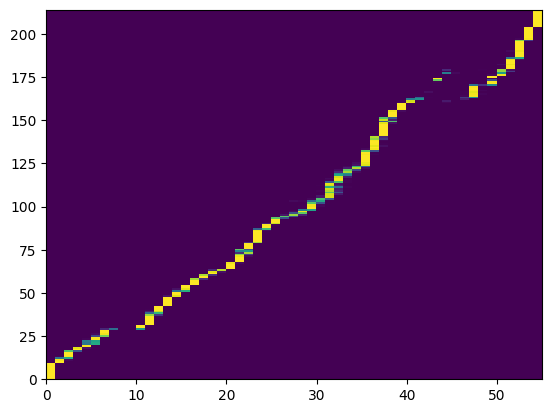

In [119]:
import matplotlib.pyplot as plt
plt.pcolor(att[0])

In [129]:
charsiu_at_al.charsiu_processor.get_phone_ids([ 'AE', 'T'])

[0, 40, 40, 22, 0]

In [128]:
charsiu_at_al.charsiu_processor.processor.tokenizer.convert_ids_to_tokens([0, 36, 22, 0],skip_special_tokens=True)


['[SIL]', 'D', 'T', '[SIL]']

In [121]:
len(sample['phonetic_detail']['utterance'])

31

/tmp/ipykernel_22846/2673428831.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  audio = torch.tensor(audio).float().unsqueeze(0).to(charsiu.device)
